실제로 충분한 크기의 데이터셋을 갖추기는 상대적으로 드물기 때문에, 맨 처음부터 합성곱 신경망(cnn) 전체를 학습하는 사람은 매우 적습니다. 대신, 매우 큰 데이터셋에서 `합성곱신경망(ConvNet)`을 미리 학습한 후, 이 합성곱 신경망을 관심있는 작업을 위한 초기 설정 또는 고정된 특징 추출기(Fixed freture extractor)로 사용합니다.

이러한 전이학습 시나리오의 주요한 2가지는 다음과 같습니다
* Finetuning : 무작위 초기화 대신, 신경망을 ImageNet 1000 데이터셋 등으로 미리 학습한 신경망으로 초기화합니다. 학습의 나머지 과정들은 평상시와 같습니다.

* 고정된 특징 추출기로써의 합성곱 신경망 : 여기서는 마지막에 완전히 연결 된 계층을 제외한 모든 신경망의 가중치를 고정합니다. 이 마지막의 완전히 연결된 계층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습합니다.

In [9]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion() # 대화형 모드

## 데이터 불러오기
데이터를 불러오기 위해 `torchvision`과 `torch.utils.data` 패키지를 사용하겠습니다.

여기서 풀고자 하는 문제는 개미 와 벌 을 분류하는 모델을 학습하는 것입니다. 개미와 벌 각각의 학습용 이미지는 대략 120장 정도있고, 75개의 검증용 이미지가 있습니다. 일반적으로 맨 처음부터 학습을 한다면 이는 일반화하기에는 아주 작은 데이터셋입니다. 하지만 우리는 전이학습을 할 것이므로, 일반화를 제법 잘 할 수 있을 것입니다.

In [10]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화

data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

data_dir = 'Static/hymenoptera_data/hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

class_names = image_datasets['train'].classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 일부 이미지 시각화하기
데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.

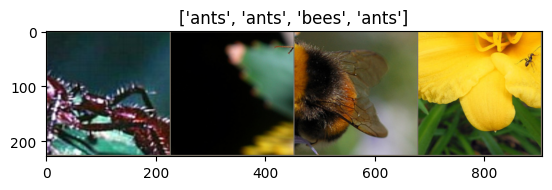

In [13]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # 갱신이 될 때까지 잠시 기다립니다.
    
# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


## 모델 학습하기
이제 모델을 학습하기 위한 일반 함수를 작성해보겠습니다. 여기서는 다음 내용들을 설명합니다.

* 학습률(Learning rate) 관리(Scheduling)
* 최적의 모델 구하기

아래에서 `scheduler` 매개변수는 `torch.optim.lr_scheduler`의 LR 스케쥴러 객체(Object)입니다.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {0} / {1}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 각 에포크는 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # 모델을 학습 모드로 설정
            else:
                model.eval() # 모델을 평가 모드로 설정
        
        running_loss = 0.0
        running_corrects = 0
        
        # 데이터를 반복
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 매개변수 경사도를 0으로 설정
            optimizer.zero_grad()
            
            #순전파
            # 학습 시에만 연산 기록을 추적
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # 학습 단계인 경우 역전파 + 최적화
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        if phase == 'train':
            scheduler.step()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # 모델을 깊은 복사(deep copy)함
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    
        print()

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model
        
                
